In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.linear_model import LinearRegression
from typing import Dict, Optional, Tuple

In [3]:
import camelsus
import pet

# Parameters

In [4]:
_TEST_YEARS = 2
_MIN_VALID_OBS_FOR_NSE_SCORE = 365
_REGRESSION_LOOKBACK = 30

# Definition of the ABCD Model

In [5]:
def _abcd_model_timestep(
    soil_moisture: float,
    groundwater_storage: float,
    precipitation: float,
    potential_et: float,
    parameters: Dict[str, float]
) -> Tuple[float, float, float]:
  """Runs one timestep of the ABCD model."""
  
  # Unpack parameters.
  a = parameters['a']
  b = parameters['b']
  c = parameters['c']
  d = parameters['d']

  # Available soil water is the total amount of water that needs to be partitioned.
  available_soil_water = soil_moisture + precipitation

  # ET is limited by available water. See primary reference for theory:
  # Thomas (1981) Improved Methods for National Water Assessment.
  et_potential = (available_soil_water + b) / (2 * a) - (((available_soil_water + b) / (2 * a))**2 - b * available_soil_water / a)**(1/2)
  soil_moisture = et_potential * np.exp(-potential_et / b)
  actual_et = et_potential * (1 - np.exp(-potential_et / b))
  actual_et = np.min([np.max([0, potential_et]), actual_et])

  # Direct runoff is the fraction of available water that does not percolate.
  direct_runoff = (1-c) * (available_soil_water - et_potential)
  
  # Groundwater components. Recharge is the balance of available water after
  # direct runoff. Baseflow is a parameterized fraction of storage.
  groundwater_storage = (c * (available_soil_water - et_potential) + groundwater_storage) / (1+d)
  baseflow = d * groundwater_storage

  # Runoff is the sum of direct runoff and baseflow.
  runoff = direct_runoff + baseflow

  return soil_moisture, groundwater_storage, runoff

In [6]:
def abcd_model(
    precipitation: np.ndarray,
    potential_et: np.ndarray,
    parameters: Dict[str, float]
) -> np.ndarray:
  """Runs the ABCD model over a timeseries of inputs.
  
  Explanation of the model:
  https://abcd.walkerenvres.com/theory.html

  Explanation of parameters:
  a: Controls the amount of runoff and recharge that occurs when the soils are under-saturated.
  b: Controls the saturation level of the soils.
  c: Defines the ratio of groundwater recharge to surface runoff.
  d: Controls the rate of groundwater discharge.

  Inputs:
  --------
    precipitation: Timeseries of precip values in arbirary units (e.g., [mm]).
    potential_et: Timeseries of potential ET values in the same units as precipitation.
    parameters: Mapping containing all four parameters listed above.

  Returns:
  --------
    Timeseries of streamflow values in the same units as precipitation.

  Raises:
  --------
    ValueError if number of timesteps in input arrays don't match.
    ValueError if all four parameters (a, b, c, d) are not present.
  """
  
  # Number of timesteps.
  num_timesteps = len(precipitation)
  if len(potential_et) != num_timesteps:
    raise ValueError(
        f'Number of timesteps in Precip {len(precipitation)} '
        f'and PET {len(potential_et)} must be the same.'
    )

  # Check all four parameters exist.
  if any([parm not in parameters for parm in ['a', 'b', 'c', 'd']]):
    raise ValueError('Paramerters are missing from the parameter mapping.')

  # A standard way to initialize a hydrology model is dry.
  # Initialize soil water at zero.
  soil_moisture = 0.
  groundwater_storage = 0.

  # Initialize storage of output values.
  runoff = np.full((num_timesteps, ), np.nan)

  # Run the model over timesteps.
  for t in range(num_timesteps):
    soil_moisture, groundwater_storage, runoff[t] = _abcd_model_timestep(
        soil_moisture,
        groundwater_storage,
        precipitation[t], 
        potential_et[t],
        parameters=parameters
    )

  return runoff

# Load Data

In [7]:
# Path to the CAMELS dataset.
camels_data_path = Path('camels_data/basin_dataset_public_v1p2')

def load_abcd_data(basin: str) -> pd.DataFrame:
    """Loads data necessary to use the ABCD model from the CAMELS-US dataset.
    
    This function uses utilities from the NeuralHydrology repository:
    https://github.com/neuralhydrology/neuralhydrology
    
    """
    # Load forcing data.
    forcings, area = camelsus.load_camels_us_forcings(
        data_dir=camels_data_path,
        basin=basin,
        forcings='daymet'
    )

    # Load catchment attributes to get latitude.
    attributes = camelsus.load_camels_us_attributes(
        data_dir=camels_data_path,
        basins=[basin]
    )

    # Calculate PET from forcing data.
    forcings['Potential ET'] = pet.get_priestley_taylor_pet(
        t_min=forcings['tmin(C)'].values,
        t_max=forcings['tmax(C)'].values,
        s_rad=forcings['srad(W/m2)'].values,
        lat=attributes.loc[basin, 'gauge_lat'],
        elev=attributes.loc[basin, 'elev_mean'],
        doy=np.array([ts.day_of_year for ts in forcings.index])
    )

    # Load area-normalized discharge.
    forcings['Observed Runoff'] = camelsus.load_camels_us_discharge(
        data_dir=camels_data_path,
        basin=basin, 
        area=area
    )

    # Ensure that all values are >= 0.
    # This only works for the columns we are using here.
    # forcings[forcings < 0] = 0

    forcings.rename(columns={'prcp(mm/day)': 'Precipitation'}, inplace=True)
    return forcings[['Precipitation', 'Potential ET', 'Observed Runoff']]


/home/gsnearing/projects/abcd_model/ABCD-Hydrology-Model/camelsus.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.QObs[df.QObs<0] = np.nan


,Precipitation,Potential ET,Observed Runoff
date,,,
1980-01-01,0.00,-0.153488,1.644439
1980-01-02,0.00,-0.178527,1.457098
1980-01-03,0.00,-0.176266,1.290572
1980-01-04,0.00,-0.096179,1.144863
1980-01-05,0.00,-0.048007,1.040784
...,...,...,...
2014-12-27,0.00,-0.236676,NaN
2014-12-28,5.31,-0.090616,NaN
2014-12-29,0.00,-0.258922,NaN


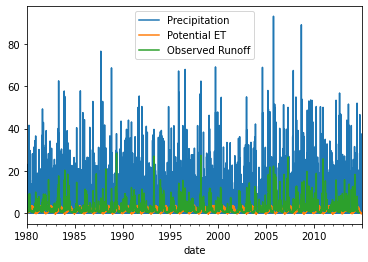

In [8]:
basin = '01022500'
data = load_abcd_data(basin=basin)
data.plot()
data

# Run the ABCD Model

## Helper Functions

In [9]:
def _calc_nse(sim: np.ndarray, obs: np.ndarray) -> float:
  mask = np.where(~(np.isnan(sim) | np.isnan(obs)))[0]
  if len(mask) < _MIN_VALID_OBS_FOR_NSE_SCORE:
    return None
  return 1 - ((sim[mask] - obs[mask])**2).mean() / ((obs[mask] - obs[mask].mean())**2).mean()

In [10]:
def run_and_plot(
    parameters: Dict[str, float],
    forcings: pd.DataFrame,
):
    """Helper function to run and plot data for manual tuning."""
    
    forcings['Simulated Runoff'] = abcd_model(
        precipitation=forcings['Precipitation'].values,
        potential_et=forcings['Potential ET'].values,
        parameters=parameters
    )

    plot_hydrographs(forcings)

In [11]:
def plot_hydrographs(data: pd.DataFrame):

    # Date range for plotting
    daterange = data.index[-365*_TEST_YEARS:]

    # Plot sim and obs runoff.
    ax = data[['Observed Runoff', 'Simulated Runoff']].loc[daterange].plot()

    score = _calc_nse(
        sim=data['Simulated Runoff'].values,
        obs=data['Observed Runoff'].values
    )

    if score is not None:
        x = ax.get_xlim()[0] + (ax.get_xlim()[1] - ax.get_xlim()[0]) * (1/50)
        y = ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * (9/10)
        ax.text(x, y, f'NSE = {score: 0.3}', fontsize=14, 
            bbox=dict(facecolor='white', edgecolor='black'))

    # Aesthetics.
    plt.grid()
    plt.legend(loc='upper right')
    plt.ylabel('Runoff [mm/day]')

# Interactive Parameter Tuning

In [12]:
from ipywidgets import *

def _interactive_plot(
    a: float,
    b: float,
    c: float,
    d: float,
):
    parameters = {
        'a': a,
        'b': b,
        'c': c,
        'd': d,
    }

    run_and_plot(parameters, data)



In [13]:
interact(
    _interactive_plot,
    a=widgets.FloatSlider(value=0.93, min=0.1, max=1, step=0.01), 
    b=widgets.FloatSlider(value=3.5, min=0, max=12, step=0.1),
    c=widgets.FloatSlider(value=0.53, min=0, max=1, step=0.01),
    d=widgets.FloatSlider(value=0.3, min=0, max=1, step=0.01),
)

interactive(children=(FloatSlider(value=0.93, description='a', max=1.0, min=0.1, step=0.01), FloatSlider(value…

<function __main__._interactive_plot(a: float, b: float, c: float, d: float)>

# Regression Model

In [14]:
def _lag_regression_inputs(data: pd.DataFrame) -> pd.DataFrame:
    num_samples = data.shape[0]
    lagged_data = np.full((num_samples, _REGRESSION_LOOKBACK*2), np.nan)
    for sample in range(_REGRESSION_LOOKBACK, num_samples):
        lagged_data[sample, :_REGRESSION_LOOKBACK] = data['Precipitation'].iloc[sample-_REGRESSION_LOOKBACK+1:sample+1]
        lagged_data[sample, _REGRESSION_LOOKBACK:] = data['Potential ET'].iloc[sample-_REGRESSION_LOOKBACK+1:sample+1]
    
    return lagged_data

In [16]:
def regression_train_and_plot(data: pd.DataFrame):

    # Lag data
    lagged_input_data = _lag_regression_inputs(data)

    # Train model.
    x_train = lagged_input_data[:-365*_TEST_YEARS, :]
    y_train = data['Observed Runoff'].values[:-365*_TEST_YEARS]

    x_mask = ~np.any(np.isnan(x_train), axis=1)
    y_mask = ~np.isnan(y_train)
    mask = np.where(x_mask & y_mask)[0]

    model = LinearRegression()
    model.fit(x_train[mask,], y_train[mask])

    # Out-of-sample predictions.
    x_test = lagged_input_data[-365*_TEST_YEARS:, :]
    y_pred = model.predict(x_test)

    # Plot and score.
    regression_data = data[['Observed Runoff']].copy()
    regression_data['Simulated Runoff'] = np.nan
    daterange = data.index[-365*_TEST_YEARS:]
    regression_data.loc[daterange, 'Simulated Runoff'] = y_pred
    plot_hydrographs(regression_data)

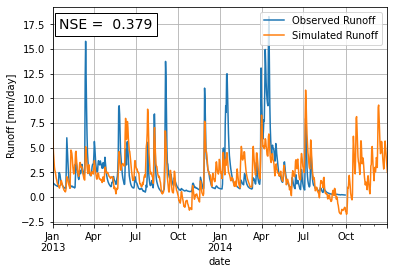

In [17]:
regression_train_and_plot(data)